In [ ]:
!pip install openpiv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 94.1 MB/s eta 0:00:00


In [ ]:
from openpiv import tools, pyprocess, validation, filters, scaling, windef
import numpy as np
import zipfile
import imageio
import matplotlib.pyplot as plt
from google.colab import drive, files
from scipy.optimize import curve_fit
from scipy.signal import correlate2d
from scipy import fft
import os
import time
from tqdm import tqdm

plt.rcParams.update({'font.size': 14})

In [ ]:
drive.mount('/content/drive')
zip_file = '/content/drive/MyDrive/expdata/data.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

Mounted at /content/drive


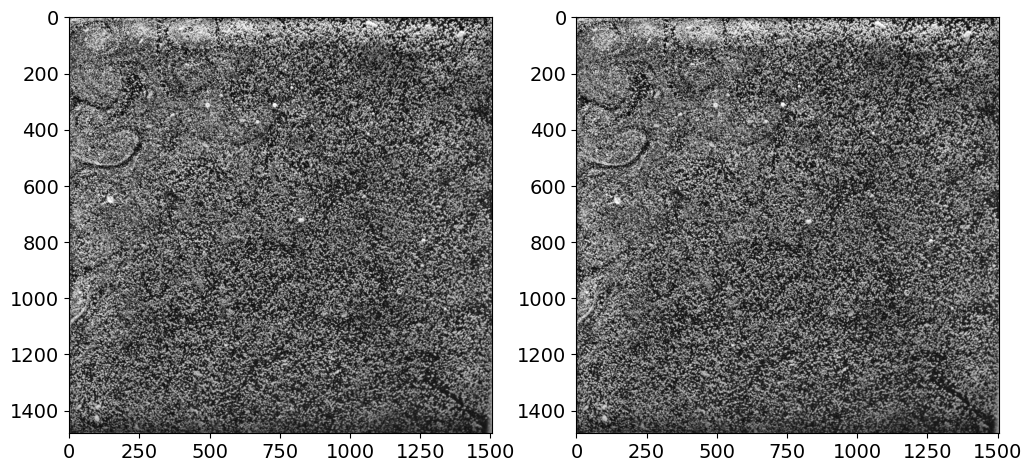

In [ ]:
frame_a  = tools.imread('data/j0700/frame.01800.gray.1481p.png')
frame_b  = tools.imread('data/j0700/frame.01801.gray.1481p.png')
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

In [ ]:
def energy(velocity_field, dx=1, dy=1, kargs=()):
    """
    Returns the energy of velocity field
    :param velocity_field: array_like
        3d input array.
    :param dx: float64
       single scalar to specify a sample distance for x-axis.
    :param dy: float64
       single scalar to specify a sample distance for y-axis.
    :return: float64
       single scalar describing total energy of velocity field.
    """
    return np.mean(velocity_field ** 2)


def enstrophy(velocity_field, dx, dy, kargs=()):
    """
    Returns the enstrophy of velocity field
    :param velocity_field: array_like
        3d input array.
    :param dx: float64
        single scalar to specify a sample distance for x-axis.
    :param dy: float64
        single scalar to specify a sample distance for y-axis.
    :return: float64
        single scalar describing enstrophy of the velocity field.
    """
    dvy_x = np.gradient(velocity_field[1, :, :], dx, axis=1)
    dvx_y = np.gradient(velocity_field[0, :, :], dy, axis=0)
    rot = dvy_x - dvx_y
    return np.mean(rot ** 2) / 2


def butterworth(x, kf=np.pi, n=16):
    return 1 / (1 + (x / kf) ** (2 * n)) ** 0.5


def low_pass(velocity_field, dx, dy, filter_args=(2/3*np.pi, 16)):
    """
    Return low pass part of the decomposition q = \bar q + \tilde q
    :param velocity_field: array_like
        2d or greater input array.
    :param dx: float64
        single scalar to specify a sample distance for x-axis.
    :param dy: float64
        single scalar to specify a sample distance for x-axis.
    :param filter_args: tuple
        arguments for the filtering function.
    :return: array_like
        output array of the same shape as input array describing low pass part of velocity.
    """
    shape = np.shape(velocity_field)
    k_x = 2 * np.pi * fft.fftfreq(shape[-1], dx)
    k_y = 2 * np.pi * fft.fftfreq(shape[-2], dy)
    k_xy = np.sqrt(np.square(k_x[np.newaxis, :]) + np.square(k_y[:, np.newaxis]))
    butterworth_wnd = butterworth(k_xy, *filter_args)
    return np.real_if_close(fft.ifft2(fft.fft2(velocity_field) * butterworth_wnd))


def energy_flux(velocity_field, dx, dy, filter_args=(2/3*np.pi, 16)):
    """
    Returns the flux of energy of velocity field
    :param velocity_field: array_like
        3d input array
    :param dx: float64
        single scalar to specify a sample distance for x-axis.
    :param dy: float64
        single scalar to specify a sample distance for y-axis.
    :param filter_args: tuple
        arguments for the filtering function.
    :return: float64
        single scalar describing energy flux of velocity field.
    """
    v_x_v_y_l = low_pass(velocity_field[0, :, :] * velocity_field[1, :, :], dx, dy, filter_args)
    v2_x_l = low_pass(velocity_field[0, :, :] ** 2, dx, dy, filter_args)
    v2_y_l = low_pass(velocity_field[1, :, :] ** 2, dx, dy, filter_args)
    v_x_l = low_pass(velocity_field[0, :, :], dx, dy, filter_args)
    v_y_l = low_pass(velocity_field[1, :, :], dx, dy, filter_args)
    dv_x_ldy = np.gradient(v_x_l, dy, axis=0)
    dv_y_ldx = np.gradient(v_y_l, dx, axis=1)
    dv_x_ldx = np.gradient(v_x_l, dx, axis=1)
    dv_y_ldy = np.gradient(v_y_l, dy, axis=0)
    flux = (v_x_v_y_l - v_x_l * v_y_l) * (dv_x_ldy + dv_y_ldx) + \
           (v2_y_l - v_y_l ** 2) * dv_y_ldy + (v2_x_l - v_x_l ** 2) * dv_x_ldx
    return np.mean(flux)


def max_energy_flux(velocity_field, dx, dy):
    """
    :param velocity_field:
    :param dx:
    :param dy:
    :return:
    """
    k_f = np.linspace(0.1, 2 * np.pi, 1000)
    flux_k = [energy_flux(velocity_field, dx, dy, (k_f[i], 16)) for i in range(1000)]
    return k_f[np.argmax(flux_k)]


def accuracy(func, velocity_field, error, dx=1, dy=1, kargs=()):
    """
    :param func:
    :param velocity_field:
    :param error:
    :param dx:
    :param dy:
    :param kargs:
    :return:
    """
    delta_f = func(velocity_field+error, dx, dy, kargs) - func(velocity_field, dx, dy, kargs)
    return delta_f


def vel_error(shape, kind, mu, st_dev):
    """
    Returns a random error of certain type.
    :param shape: tuple of int
        shape of output array.
    :param kind: string
        type of error distribution.
    :param mu: float64
        mean of error distribution.
    :param st_dev: float64
        standard deviation of error distribution.
    :return: array_like
        3d output array.
    """
    n_x = shape[0]
    n_y = shape[1]
    if kind == 'gauss':
        mis = np.random.normal(mu, st_dev, size=(2, n_x, n_y))
        return mis
    if kind == 'laplace':
        mis = np.random.laplace(mu, st_dev/np.sqrt(2), size=(2, n_x, n_y))
        return mis
    if kind == 'uniform':
        mis = st_dev * (np.random.random_sample((2, n_x, n_y)) - 1/2)
        return mis
    if kind == 'discrete':
        mis = np.random.randint(-1, 2, (2, n_x, n_y)) * st_dev
        return mis


def func_error(k, func, velocity_field, shape, kind, mu, st_dev, dx=1, dy=1, kargs=(), ampl=1):
    """
    Returns array of relative errors for k different samples.
    :param k: int
        number of samples of the error.
    :param func: callable
        function for which the error distribution is calculated.
    :param velocity_field: array_like
        3d input array.
    :param shape: tuple of int
        shape of error array.
    :param kind: string
        type of error distribution.
    :param mu: float64
        mean of error distribution.
    :param st_dev: float64
        standard deviation of error distribution.
    :param dx: float64
        single scalar to specify a sample distance for x-axis.
    :param dy: float64
        single scalar to specify a sample distance for x-axis.
    :param kargs: tuple
        additional function arguments (example: filter scale and order of filter for energy flux).
    :param ampl: array_like
        amplitude of velocity error for each velocity vector.
    :return: array_like
        1d array containing absolute errors.
    """
    ac_abs = [accuracy(func, velocity_field, vel_error(shape, kind, mu, st_dev) * ampl, dx, dy, kargs) for i in range(k)]
    return np.array(ac_abs)


def mean(func, k, sigma, velocity_field, kind, dx=1, dy=1, kargs=(), ampl=1):
    """
    :param func:
    :param k:
    :param sigma:
    :param velocity_field:
    :param kind:
    :param dx:
    :param dy:
    :param kargs:
    :param method:
    :return:
    """
    n_x, n_y = np.shape(velocity_field[1, :, :])
    return [np.mean(func_error(k, func, velocity_field, (n_x, n_y), kind, sigma, dx, dy, kargs, ampl)) for sigma in sigma]


def standard_deviation(func, k, sigma, velocity_field, kind, dx=1, dy=1, kargs=(), ampl=1):
    """
    :param func:
    :param k:
    :param sigma:
    :param velocity_field:
    :param kind:
    :param dx:
    :param dy:
    :param kargs:
    :param method:
    :return:
    """
    n_x, n_y = np.shape(velocity_field[1, :, :])
    n = np.shape(sigma)
    dev = np.zeros(n)
    for i in range(*n):
        a = func_error(k, func, velocity_field, (n_x, n_y), kind, sigma[i], dx, dy, kargs, ampl)
        dev[i] = np.sqrt(np.mean(a ** 2) - np.mean(a) ** 2)
    return dev


def first_n_max(n, func):
    """
    :param n:
    :param func:
    :return:
    """
    index_of_max = []
    while len(index_of_max) < n:
        maximum = np.max(func)
        index = np.where(func == maximum)
        indexes = list(zip(index[0], index[1]))
        shape = np.array(indexes).shape[0]
        for j in range(shape):
            func[indexes[j]] = 0
            index_of_max.append(indexes[j])
    return index_of_max


def linear(x, a):
    return a*x


def pic_to_error(image_a, image_b, num, wave_number, scaling_factor, dt):
    """
    :param image_a:
    :param image_b:
    :param num:
    :param wave_number:
    :param scaling_factor:
    :param dt:
    :return:
    """
    settings = windef.PIVSettings()
    settings.num_iterations = 5
    settings.windowsizes = (64, 32, 32, 32, 32)
    settings.overlap = (32, 16, 16, 16, 16)
    settings.scaling_factor = 1
    settings.dt = 1
    settings.subpixel_method = 'gaussian'
    settings.interpolation_order = 3
    settings.sig2noise_validate = False
    settings.validation_first_pass = False
    settings.std_threshold = 7
    settings.min_max_u_disp = (-8, 8)
    settings.min_max_v_disp = (-8, 8)
    settings.median_threshold = 3
    settings.replace_vectors = True
    settings.filter_method = 'localmean'
    settings.max_filter_iteration = 4
    settings.filter_kernel_size = 3
    x, y, u, v, flags = windef.simple_multipass(image_a, image_b, settings)
    y = y[::-1, :]
    v = (-1) * v
    dx = (x[0, 1] - x[0, 0]) / scaling_factor
    dy = (y[1, 0] - y[0, 0]) / scaling_factor
    vel_field = np.array([u, v])
    fourier_vel_field = np.fft.fft2(vel_field)
    m, n = np.meshgrid(np.arange(0, x.shape[1]), np.arange(0, x.shape[0]))
    shape_x = x.shape[1]
    shape_y = x.shape[0]
    a1 = list(map(int, np.zeros(num)))
    b1 = list(np.arange(num))
    for i in range(num - 1):
        a1 += list(map(int, (i + 1) * np.ones(num)))
        b1 += list(b1)
    a2 = list(map(int, (shape_y - 1) * np.ones(num)))
    b2 = list(np.arange(shape_x - num, shape_x))
    for i in range(num - 1):
        a2 += list(map(int, (shape_y - i - 2) * np.ones(num)))
        b2 += list(b2)
    harmonics = list(zip(a1, b1)) + list(zip(a1, b2)) + list(zip(a2, b1)) + list(zip(a2, b2))
    u_def = 0
    v_def = 0
    for (l, k) in harmonics:
        u_def += fourier_vel_field[0, l, k] \
                 * np.exp(1j * 2 * np.pi * (k * (m / m.shape[1]) + l * (n / n.shape[0])))
    for (l, k) in harmonics:
        v_def += fourier_vel_field[1, l, k] \
                 * np.exp(1j * 2 * np.pi * (k * (m / m.shape[1]) + l * (n / n.shape[0])))
    full_energy = energy(vel_field)
    energy_def = energy(np.array([u_def, v_def]))
    norm = np.sqrt(full_energy / energy_def)
    u_def = np.real_if_close(norm * u_def)
    v_def = np.real_if_close(norm * v_def)
    image_a_new = windef.deform_windows(image_a, x, y, -u_def, -v_def)
    image_b_new = windef.deform_windows(image_b, x, y, u_def, v_def)
    x_art, y_art, u_art, v_art, flags_art = windef.simple_multipass(image_a, image_a_new, settings)
    x_art_inv, y_art_inv, u_art_inv, v_art_inv, flags_art_inv = windef.simple_multipass(image_b_new, image_b, settings)
    delta = abs((energy(np.array([u_art, v_art])) + energy(np.array([u_art_inv, v_art_inv]))) / 2
                - energy(vel_field))
    sigma_0 = np.sqrt(delta / full_energy)
    sigma = np.linspace(0.01, 0.1, 50)
    calibration = standard_deviation(energy_flux, 200, sigma, vel_field / (scaling_factor * dt), 'gauss', dx, dy,
                                     (wave_number, 16))
    flux_error = curve_fit(linear, sigma, calibration)[0][0] * sigma_0
    flux = energy_flux(vel_field / (scaling_factor * dt), dx, dy, filter_args=(wave_number, 16))
    return flux, flux_error


def pic2vel(image_a, image_b):
    """
    :param image_a:
    :param image_b:
    :return:
    """
    settings = windef.PIVSettings()
    settings.num_iterations = 5
    settings.windowsizes = (64, 32, 32, 32, 32)
    settings.overlap = (32, 16, 16, 16, 16)
    settings.scaling_factor = 1
    settings.dt = 1
    settings.subpixel_method = 'gaussian'
    settings.interpolation_order = 3
    settings.sig2noise_validate = False
    settings.validation_first_pass = False
    settings.std_threshold = 7
    settings.min_max_u_disp = (-8, 8)
    settings.min_max_v_disp = (-8, 8)
    settings.median_threshold = 3
    settings.replace_vectors = True
    settings.filter_method = 'localmean'
    settings.max_filter_iteration = 4
    settings.filter_kernel_size = 3
    x, y, u, v, flags = windef.simple_multipass(image_a, image_b, settings)
    y = y[::-1, :]
    v = (-1) * v
    return np.array([u, v]), x, y


def deformation_field(velocity_field):
    """
    :param velocity_field:
    :return:
    """
    fourier_vel_field = np.fft.fft2(velocity_field)
    shape_x = velocity_field.shape[2]
    shape_y = velocity_field.shape[1]
    m, n = np.meshgrid(np.arange(0, shape_x), np.arange(0, shape_y))
    num = int(np.round(np.sqrt(shape_x * shape_y * 0.1) / 2))
    index_x1 = list(map(int, np.zeros(num)))
    index_y1 = list(np.arange(num))
    for i in range(num - 1):
        index_x1 += list(map(int, (i + 1) * np.ones(num)))
        index_y1 += list(index_y1)
    index_x2 = list(map(int, (shape_y - 1) * np.ones(num)))
    index_y2 = list(np.arange(shape_x - num, shape_x))
    for i in range(num - 1):
        index_x2 += list(map(int, (shape_y - i - 2) * np.ones(num)))
        index_y2 += list(index_y2)
    harmonics = list(zip(index_x1, index_y1)) + list(zip(index_x1, index_y2)) +\
        list(zip(index_x2, index_y1)) + list(zip(index_x2, index_y2))
    u_def = 0
    v_def = 0
    for (l, k) in harmonics:
        u_def += fourier_vel_field[0, l, k] \
                 * np.exp(1j * 2 * np.pi * (k * (m / m.shape[1]) + l * (n / n.shape[0])))
    for (l, k) in harmonics:
        v_def += fourier_vel_field[1, l, k] \
                 * np.exp(1j * 2 * np.pi * (k * (m / m.shape[1]) + l * (n / n.shape[0])))
    full_energy = energy(velocity_field)
    energy_def = energy(np.array([u_def, v_def]))
    norm = np.sqrt(full_energy / energy_def)
    u_def = np.real(norm * u_def)
    v_def = np.real(norm * v_def)
    return np.array([u_def, v_def])


def pic2error(image_a, image_b, wave_number, scaling_factor, dt):
    """
    :param image_a: array_like
        a two dimensions array of integers containing grey levels of the first experimental PIV frame.
    :param image_b: array_like
        a two dimensions array of integers containing grey levels of the second experimental PIV frame.
    :param wave_number:
    :param scaling_factor: float
        the image scaling factor in pixels per centimeter.
    :param dt: float
        the time delay separating the two frames.
    :return:
    """
    vel_field, x, y = pic2vel(image_a, image_b)
    dx = (x[0, 1] - x[0, 0]) / scaling_factor
    dy = (y[1, 0] - y[0, 0]) / scaling_factor
    (n_x, n_y) = (x.shape[0], x.shape[1])
    def_vel = deformation_field(vel_field)
    image_a_new = windef.deform_windows(image_a, x, y, -def_vel[0, :, :], def_vel[1, :, :])
    image_b_new = windef.deform_windows(image_b, x, y, def_vel[0, :, :], -def_vel[1, :, :])
    vel_field_art, x_art, y_art = pic2vel(image_a, image_a_new)
    vel_field_art_inv, x_art_inv, y_art_inv = pic2vel(image_b_new, image_b)
    deltav = vel_field - (vel_field_art + vel_field_art_inv) / 2
    mu = np.mean(deltav)
    sigma = np.sqrt(np.mean(deltav ** 2) - np.mean(deltav) ** 2)
    flux_error_dist = func_error(1000, energy_flux, def_vel / (scaling_factor * dt), (n_x, n_y), 'gauss', mu, sigma, dx, dy, kargs=(wave_number, 16))
    flux_error_mean = np.mean(flux_error_dist)
    flux_error_dev = np.sqrt(np.mean(flux_error_dist ** 2) - np.mean(flux_error_dist) ** 2)
    flux = energy_flux(vel_field / (scaling_factor * dt), dx, dy, filter_args=(wave_number, 16))
    return flux, flux_error_mean, flux_error_dev


def deform_image(image, x, y, u, v):
  image_new = windef.deform_windows(image, x, y, -u * 0.1, v * 0.1)
  for i in range(9):
    image_new = windef.deform_windows(image_new, x, y, -u * 0.1, v * 0.1)
  return image_new


In [ ]:
"""
  x_midmask = x.all() <= c and x.all() >= -c
  x_leftmask = x.all() < -c
  x_rightmask = x.all() > c
  x_mid = np.where(x_midmask, x, 0)
  x_left = np.where(x_leftmask, x, 0)
  x_right = np.where(x_rightmask, x, 0)
  f_left = 1/(4*b) * (np.exp(-np.abs(x_left-a) / b) + np.exp(-np.abs(x_left+a) /b))
  f_mid = 1/(4*b) * (np.exp(-np.abs(x_left-a) / b) + np.exp(-np.abs(x_left+a) /b)) + 1/(2*c)
  f_right = 1/(4*b) * (np.exp(-np.abs(x_left-a) / b) + np.exp(-np.abs(x_left+a) /b))

    if x.all() < c and x.all() > -c:
    return 1/(4*b) * (np.exp(-np.abs(x-a) / b) + np.exp(-np.abs(x+a) /b)) + 1/(2*c)
  else:
    return 1/(4*b) * (np.exp(-np.abs(x-a) / b) + np.exp(-np.abs(x+a) /b))
"""

def density_func(x,a,b):
  return 1/(4*b) * (np.exp(-np.abs(x-a) / b) + np.exp(-np.abs(x+a) /b))

def laplace_rand(mu, sigma):
    while True:
        a = np.random.uniform(-0.5,0.5)
        b = np.random.uniform(0,1) * (1/(4*sigma) * (1+np.exp(-2*mu/sigma)))
        if b <= density_func(a, mu, sigma):
            return a

def double_laplace_rand(mu, sigma, size):
    dist = np.zeros(2*size[0]*size[1])
    for i in range(2*size[0]*size[1]):
      num = np.random.randint(1, 3)
      if num == 1:
        dist[i] = np.random.laplace(mu, sigma)
      if num == 2:
        dist[i] = np.random.laplace(-mu, sigma)
    return np.reshape(dist, (2, size[0], size[1]))

def dist_by_hist(hist, size):
    dist = np.zeros(2*size[0]*size[1])
    dx = hist[1][1] - hist[1][0]
    cdf = [np.sum(hist[0][0:i]) * dx for i in range(len(hist[0]))]
    unif = np.random.uniform(0, 1, size=2*size[0]*size[1])
    ind = np.searchsorted(cdf, unif)
    np.place(ind, ind == 500, 499)
    end = int(*np.shape(hist[0]))
    for i in range(2*size[0]*size[1]):
        dist[i] = hist[1][0:end][ind[i] - 1] \
                  + ((hist[1][0:end][ind[i]] - hist[1][0:end][ind[i]-1]) / (cdf[ind[i]] - cdf[ind[i] - 1])) \
                  * (unif[i] - cdf[ind[i]-1])
    np.place(dist, np.isinf(dist), hist[1][end])
    return np.reshape(dist, (2, size[0], size[1]))

Оценка пространственных корреляций погрешности поля скорости:

In [ ]:
vel_field, x, y = pic2vel(frame_a, frame_b)
dx = (x[0, 1] - x[0, 0]) / 151
dy = (y[1, 0] - y[0, 0]) / 151
def_vel = deformation_field(vel_field)
image_a_new = windef.deform_windows(frame_a, x, y, -def_vel[0, :, :], def_vel[1, :, :])
image_b_new = windef.deform_windows(frame_b, x, y, def_vel[0, :, :], -def_vel[1, :, :])
image_a_new0 = deform_image(frame_a, x, y, def_vel[0, :, :], def_vel[1, :, :])
image_b_new0 = deform_image(frame_b, x, y, -def_vel[0, :, :], -def_vel[1, :, :])
vel_field_art0, x_art, y_art = pic2vel(frame_a, image_a_new0)
vel_field_art_inv0, x_art_inv, y_art_inv = pic2vel(image_b_new0, frame_b)
sigma = np.linspace(0.01, 0.1, 50)
delta_v10 = def_vel - vel_field_art0
delta_v20 = def_vel - vel_field_art_inv0
delta_v0 = np.concatenate((delta_v10, delta_v20))

In [ ]:
delta_vabs = np.concatenate((np.sqrt(delta_v10[0,:,:] ** 2 + delta_v10[1,:,:] ** 2), np.sqrt(delta_v20[0,:,:] ** 2 + delta_v20[1,:,:] ** 2))) 

In [ ]:
def exponent(x, a, l):
  return a*np.exp(-x/l)

[]
(array([90]), array([92]))
[2.24250584e+02 1.78970810e-01] [1.06862585e+01 8.74696646e-03]


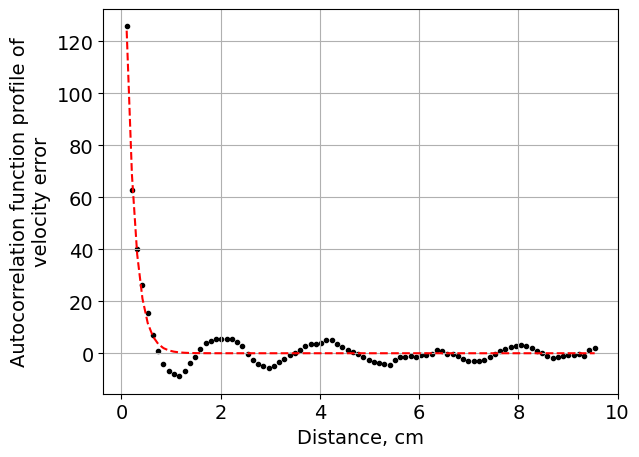

In [ ]:
cross_x = correlate2d(delta_v10[1,:,:], delta_v10[1,:,:], mode = 'full')
cross_y = correlate2d(delta_v10[0,:,:], delta_v10[0,:,:], mode = 'full')
profile = (cross_x[90,92:-3] + np.flip(cross_x[90, 2:92]) + np.flip(cross_x[0:90, 92]) + cross_x[90:-1, 92]) / 4
print(cross_x[90, 92:2])
#plt.contourf(x,y,cross_x)
#plt.colorbar()

plt.scatter(x[0][0:90] / 151, profile, color='black', marker='.')
popt, pcov = curve_fit(exponent, x[0][0:90] / 151, profile)
plt.plot(x[0][0:90] / 151, exponent(x[0][0:90] / 151, popt[0], popt[1]), 'r--')
plt.grid()
print(np.where(cross_y == np.max(cross_y)))
print(popt, np.sqrt(np.diag(pcov)))
plt.xlabel('Distance, cm')
plt.ylabel('Autocorrelation function profile of velocity error', wrap='True')
plt.tight_layout()

Метод генерации ошибки поля скорости:

Text(0.5, 1.0, 'velocity field')

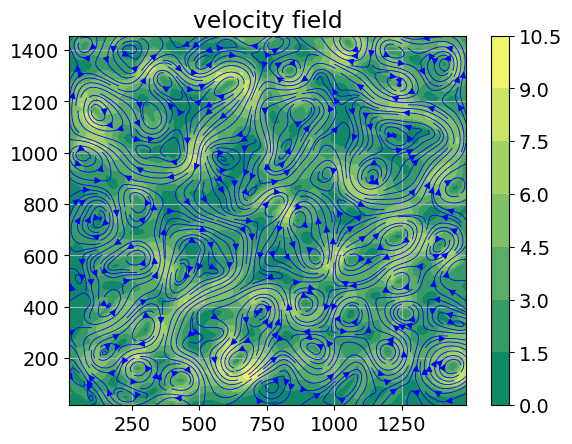

In [ ]:
absv = np.sqrt(vel_field[0,:,:] ** 2 + vel_field[1,:,:] ** 2)
plt.streamplot(x,y,vel_field[0,:,:],vel_field[1,:,:], density=3, linewidth=0.6, color='b')
plt.contourf(x, y, absv, cmap='summer')
plt.colorbar()
plt.grid()
plt.title('velocity field')

Text(0.5, 1.0, 'velocity field')

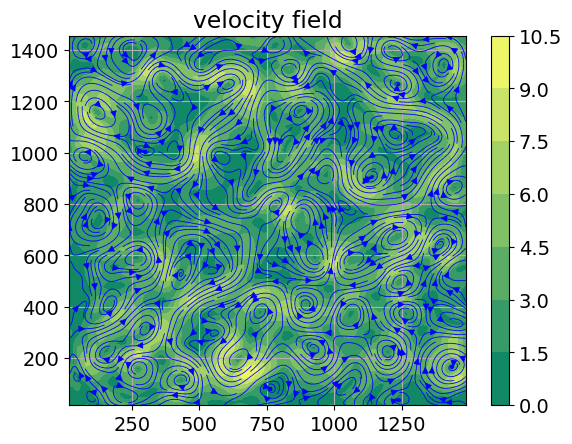

In [ ]:
absv = np.sqrt(vel_field_art[0,:,:] ** 2 + vel_field_art[1,:,:] ** 2)
plt.streamplot(x,y,vel_field_art[0,:,:],vel_field_art[1,:,:], density=3, linewidth=0.6, color='b')
plt.contourf(x, y, absv, cmap='summer')
plt.colorbar()
plt.grid()
plt.title('velocity field')

In [ ]:
parallel_def10 = (delta_v10[0,:,:] * def_vel[0,:,:] + delta_v10[1,:,:] * def_vel[1,:,:]) / (def_vel[1,:,:] ** 2 + def_vel[0,:,:] ** 2) * def_vel
orth_def10 = delta_v10 - parallel_def10
parallel_def20 = (delta_v20[0,:,:] * def_vel[0,:,:] + delta_v20[1,:,:] * def_vel[1,:,:]) / (def_vel[1,:,:] ** 2 + def_vel[0,:,:] ** 2) * def_vel
orth_def20 = delta_v20 - parallel_def20
parallel_def = np.concatenate((parallel_def10, parallel_def20))
orth_def = np.concatenate((orth_def10, orth_def20))
print(parallel_def)
trig_field = def_vel / np.sqrt(def_vel[0,:,:] ** 2 + def_vel[1,:,:] ** 2)


[[[-0.03082004  0.07305512  0.19858223 ... -0.25260585 -0.29483099
   -0.11831062]
  [-0.01386047  0.00765332  0.05407182 ...  0.05416868  0.01292151
   -0.00867517]
  [ 0.02705816  0.13410768  0.0908983  ... -0.15366937 -0.18871923
   -0.06236073]
  ...
  [-0.00434003  0.00783414  0.01569032 ...  0.03964447 -0.19508606
   -0.00737709]
  [-0.00210154  0.0550732   0.23090397 ...  0.02711168 -0.30858797
   -0.08673001]
  [ 0.00111874 -0.03355514  0.15860203 ...  0.19016965 -0.09696034
    0.05056371]]

 [[ 0.13900907  0.10839923  0.02196381 ...  0.08759536  0.19690621
    0.15467701]
  [ 0.07466211  0.01487367 -0.05979673 ...  0.01503477 -0.0050934
    0.01523707]
  [ 0.13050259  0.05033329 -0.11244987 ... -0.08515904 -0.01096971
    0.11051725]
  ...
  [ 0.07635488  0.04226908  0.04582772 ... -0.04259914  0.29702841
    0.01983639]
  [ 0.1605168   0.12584471  0.26650956 ... -0.02334955  0.36794962
    0.18078547]
  [-0.02007172 -0.0511469   0.0976479  ... -0.12381365  0.08835982
   -0.0

In [ ]:
np.allclose(parallel_def+orth_def, delta_v0)

True

In [ ]:
dist1 = parallel_def.flatten() / (151 * 0.02)
dist2 = orth_def.flatten() / (151 * 0.02)

параллельная компонента

0.00045293764289437184 0.037881548147808246


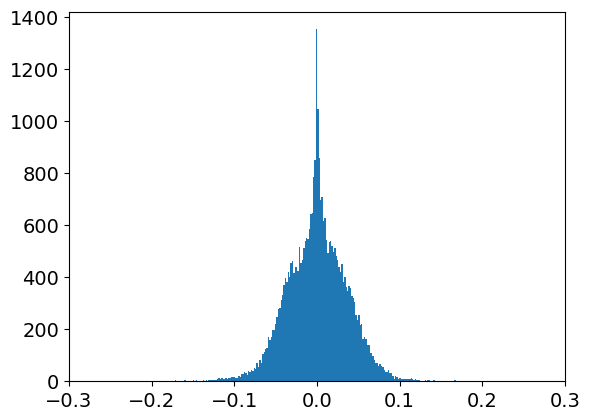

In [ ]:
gamma = plt.hist(dist1, bins=1000)
plt.xlim([-0.3,0.3])
print(np.mean(dist1), np.std(dist1))

ортогональная компонента

0.00026557945695938597 0.02187256845976115


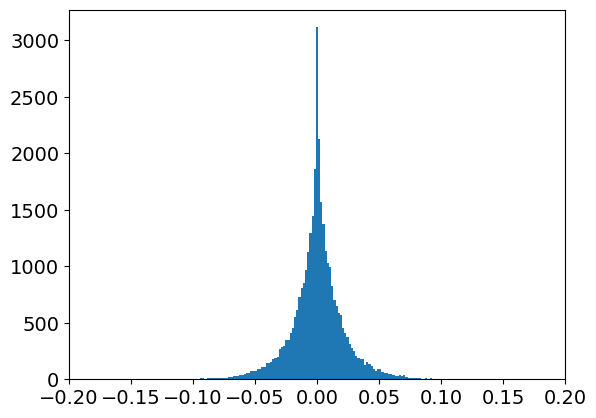

In [ ]:
h = plt.hist(dist2, bins=200)
plt.xlim([-0.2,0.2])
print(np.mean(dist2), np.std(dist2))

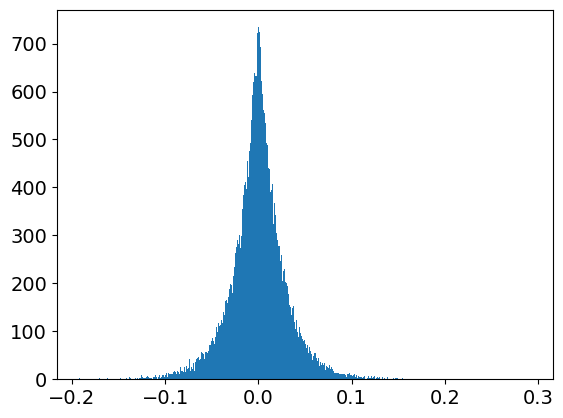

In [ ]:
h = plt.hist(np.random.laplace(np.mean(dist2), np.std(dist2), size=np.shape(dist2)), bins=500)

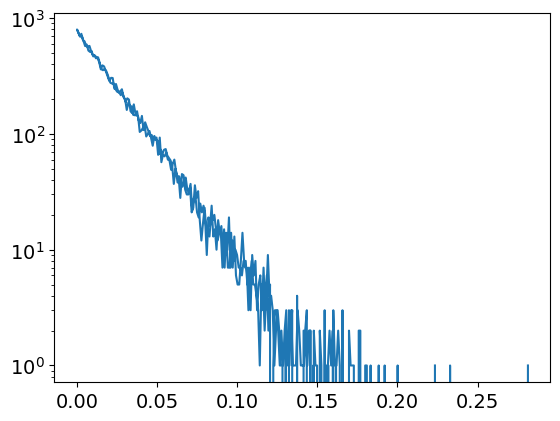

In [ ]:
plt.plot(np.abs(h[1][0:500]), h[0])
plt.yscale('log')

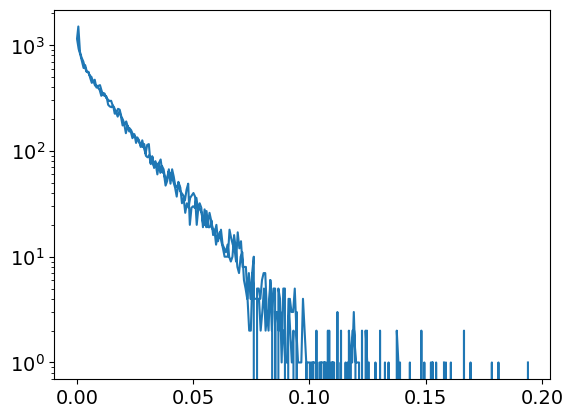

In [ ]:
plt.plot(np.abs(gamma[1][0:500]), gamma[0])
plt.yscale('log')

Просто deltav

0.0004889274077691486 0.05526050406950244


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

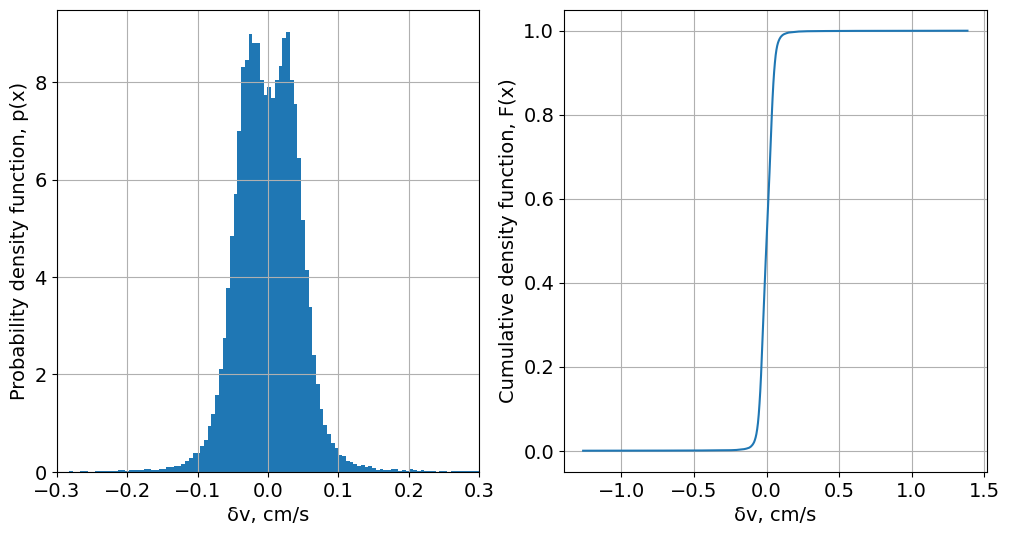

In [ ]:
dist = delta_v0.flatten()/ (151*0.02)
f, ax = plt.subplots(1,2, figsize=(12,6))
h = ax[0].hist(dist, bins=500, density='true')
mu = np.mean(dist)
std = np.std(dist)
ax[0].set_xlim([-0.3,0.3])
print(mu, std)
ax[0].set_ylabel('Probability density function, p(x)')
ax[0].set_xlabel('δv, cm/s')
ax[0].grid()
dh = h[1][1] - h[1][0]
cum = [np.sum(h[0][0:i]) * dh for i in range(len(h[0]))]
ax[1].plot(h[1][0:500], cum)
ax[1].grid()
ax[1].set_ylabel('Cumulative density function, F(x)')
ax[1].set_xlabel('δv, cm/s')
plt.savefig('dist.png', dpi=500)
files.download('dist.png')

0.00109471015238557 0.05450970012945082


(-0.3, 0.3)

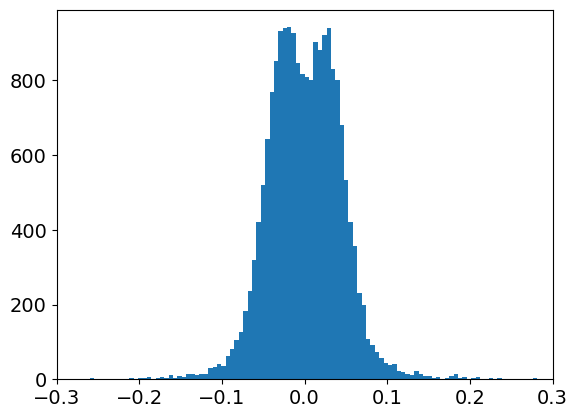

In [ ]:
plt.hist(dist_by_hist(h, (100,100)).flatten(), bins=500)
print(np.mean(dist_by_hist(h, (100,100))), np.std(dist_by_hist(h, (100,100))))
plt.xlim([-0.3,0.3])

In [ ]:
unif = np.random.uniform(0,1, size=16000)
ind = np.searchsorted(cum, unif)
print(ind)
new_dist = np.zeros(len(unif))
for i in range(16000):
  new_dist[i] = h[1][0:500][ind[i] - 1] + ((h[1][0:500][ind[i]] - h[1][0:500][ind[i]-1]) / (cum[ind[i]] - cum[ind[i] - 1])) * (unif[i] - cum[ind[i]-1])

[223 219 242 ... 247 228 247]


In [ ]:
np.place(ind, ind == 500, 499)
print(ind[np.argmax(ind)])

499


(-0.3, 0.3)

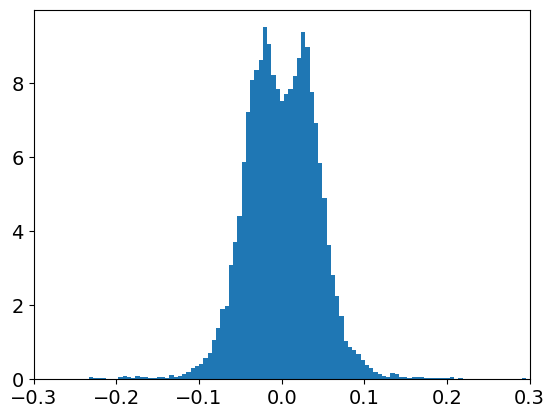

In [ ]:
h2 = plt.hist(new_dist, bins=500, density='true')
plt.xlim([-0.3,0.3])

6.95765134559861e-05 0.05518897055062143


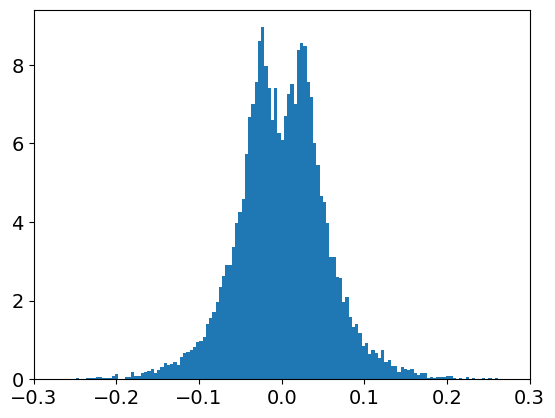

In [ ]:
dist = double_laplace_rand(0.026, 0.034, (np.shape(delta_v0[0,:,:]))).flatten()
h0 = plt.hist(dist, bins=200, density='true')
plt.xlim([-0.3,0.3])
print(np.mean(dist), np.std(dist))

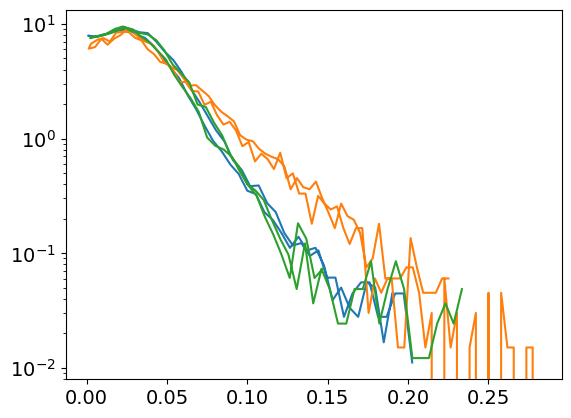

In [ ]:
plt.plot(np.abs(h[1][200:275]), h[0][200:275])
plt.plot(np.abs(h0[1][40:170]), h0[0][40:170])
plt.plot(np.abs(h2[1][200:275]), h2[0][200:275])
plt.yscale('log')

(array([0.02620094, 0.02785567]), array([[ 2.74214089e-08, -1.40936194e-08],
       [-1.40936194e-08,  8.87879102e-08]]))


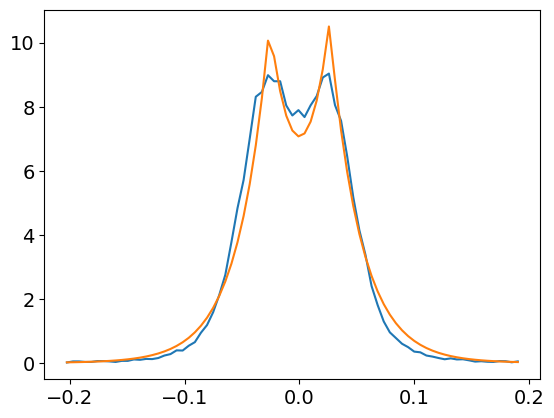

In [ ]:
plt.plot(h[1][200:275], h[0][200:275] / (np.sum(h[0])*(h[1][1] - h[1][0])))
parameters = curve_fit(density_func, h[1][0:500], h[0], p0=(0.01, 0.01))
print(parameters)
plt.plot(h[1][200:275], density_func(h[1][200:275], 0.026, 0.027))


Вычисление погрешности потока энергии:

100%|██████████| 31/31 [31:06<00:00, 60.20s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[-1.20797444e-04 -3.38412770e-04  3.66337056e-04 -7.85666322e-05
  2.33423778e-04 -3.31523975e-04 -2.51005629e-05 -9.58750077e-05
 -1.48571672e-04 -5.12887199e-04  1.07230428e-04  1.25604526e-04
  1.52072422e-04  1.03525284e-04  3.33423604e-04  1.02093022e-06
  1.64411331e-04 -9.27692211e-05  1.59885386e-05 -1.51895242e-04
 -3.16639832e-04  9.58536929e-05  1.36754412e-04  6.18175892e-06
  5.22243647e-04 -6.49820168e-05 -6.88769673e-05  2.02877272e-04
 -4.65304911e-05  5.37203114e-04 -1.59726014e-04] [0.00805266 0.00800111 0.00813559 0.00700613 0.00697214 0.00769983
 0.0070116  0.00684731 0.00850649 0.00761534 0.00711802 0.00660633
 0.00660335 0.00705508 0.00713853 0.0067406  0.00623588 0.0065004
 0.00695671 0.00682357 0.00675475 0.00741918 0.0070181  0.00615896
 0.00702288 0.00744608 0.00701996 0.00739715 0.00767125 0.00696982
 0.00765386]


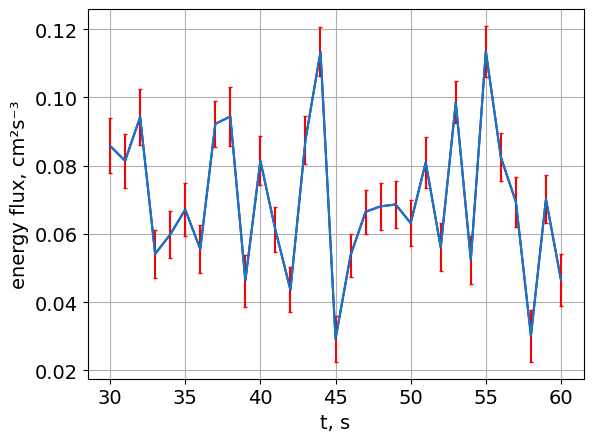

In [ ]:
t = np.arange(30, 60.01, 1)
flux = np.zeros(len(t))
flux_errormean = np.zeros(len(t))
flux_errordev = np.zeros(len(t))
for i in tqdm(range(len(t))):
  frame_a  = tools.imread('data/j0580/frame.0' + str(1500 + 50*i) + '.gray.1481p.png')
  frame_b  = tools.imread('data/j0580/frame.0' + str(1500 + 50*i + 1) + '.gray.1481p.png')
  flux[i], flux_errormean[i], flux_errordev[i] = pic2error(frame_a, frame_b, 3.9, 151, 0.02)

plt.errorbar(t, flux, yerr=flux_errordev, capsize=1.5, ecolor='red')
plt.plot(t, flux, color='blue')
plt.xlabel('t, s')
plt.ylabel('energy flux, cm²s⁻³')
plt.grid()
plt.savefig('flux_j0580.png', dpi=500)
np.save('flux_errormean_j0580', flux_errormean)
np.save('flux_errordev_j0580', flux_errordev)
np.save('flux_j0580', flux)
files.download('flux_j0580.npy')
files.download('flux_j0580.png')
files.download('flux_errormean_j0580.npy')
files.download('flux_errordev_j0580.npy')
print(flux_errormean, flux_errordev)

Вычисление числа рейнольдса и среднеквадратичной скорости:

In [ ]:
t = np.arange(30, 60.01, 1)
v_mean = np.zeros(len(t))
for i in tqdm(range(len(t))):
  frame_a  = tools.imread('data/j0700/frame.0' + str(1500 + 50*i) + '.gray.1481p.png')
  frame_b  = tools.imread('data/j0700/frame.0' + str(1500 + 50*i + 1) + '.gray.1481p.png')
  vel, x, y = pic2vel(frame_a, frame_b)
  vel = vel / (151 * 0.02)
  v_mean[i] = np.sqrt(2*energy(vel))
Re = np.mean(v_mean) * np.sqrt(2) / 0.0085
print(v_mean, Re)

100%|██████████| 31/31 [10:18<00:00, 19.94s/it]

[1.25426682 1.29502933 1.262583   1.24587766 1.22667449 1.24071754
 1.22959371 1.26073537 1.29169596 1.30878892 1.28588064 1.24580381
 1.21953721 1.26266112 1.25824026 1.27893623 1.28300668 1.29007643
 1.32273706 1.23102372 1.24838189 1.23052773 1.26873889 1.26886969
 1.2584004  1.2259542  1.23917011 1.26718069 1.31210313 1.3141863
 1.26268228] 210.33440668159088


In [ ]:
flux_j0070 = np.load('/content/drive/MyDrive/expdata/flux_j0070.npy')
flux_j0250 = np.load('/content/drive/MyDrive/expdata/flux_j0250.npy')
flux_j0460 = np.load('/content/drive/MyDrive/expdata/flux_j0460.npy')
flux_j0580 = np.load('/content/drive/MyDrive/expdata/flux_j0580.npy')
flux_j0700 = np.load('/content/drive/MyDrive/expdata/flux_j0700.npy')
flux_errormean_j0070 = np.load('/content/drive/MyDrive/expdata/flux_errormean_j0070_laplace.npy')
flux_errormean_j0250 = np.load('/content/drive/MyDrive/expdata/flux_errormean_j0250_laplace.npy')
flux_errormean_j0460 = np.load('/content/drive/MyDrive/expdata/flux_errormean_j0460_laplace.npy')
flux_errormean_j0580 = np.load('/content/drive/MyDrive/expdata/flux_errormean_j0580_laplace.npy')
flux_errormean_j0700 = np.load('/content/drive/MyDrive/expdata/flux_errormean_j0700_laplace.npy')
flux_errordev_j0070 = np.load('/content/drive/MyDrive/expdata/flux_errordev_j0070_laplace.npy')
flux_errordev_j0250 = np.load('/content/drive/MyDrive/expdata/flux_errordev_j0250_laplace.npy')
flux_errordev_j0460 = np.load('/content/drive/MyDrive/expdata/flux_errordev_j0460_laplace.npy')
flux_errordev_j0580 = np.load('/content/drive/MyDrive/expdata/flux_errordev_j0580_laplace.npy')
flux_errordev_j0700 = np.load('/content/drive/MyDrive/expdata/flux_errordev_j0700_laplace.npy')
mean_j0070 = np.mean(flux_j0070)
mean_j0250 = np.mean(flux_j0250)
mean_j0460 = np.mean(flux_j0460)
mean_j0580 = np.mean(flux_j0580)
mean_j0700 = np.mean(flux_j0700)
dev_j0070 = np.std(flux_j0070)
dev_j0250 = np.std(flux_j0250)
dev_j0460 = np.std(flux_j0460)
dev_j0580 = np.std(flux_j0580)
dev_j0700 = np.std(flux_j0700)
errormean_j0070 = np.mean(flux_errordev_j0070)
errormean_j0250 = np.mean(flux_errordev_j0250)
errormean_j0460 = np.mean(flux_errordev_j0460)
errormean_j0580 = np.mean(flux_errordev_j0580)
errormean_j0700 = np.mean(flux_errordev_j0700)
errordev_j0070 = np.std(flux_errordev_j0070)
errordev_j0250 = np.std(flux_errordev_j0250)
errordev_j0460 = np.std(flux_errordev_j0460)
errordev_j0580 = np.std(flux_errordev_j0580)
errordev_j0700 = np.std(flux_errordev_j0700)

In [ ]:
def power(x, a, b):
  return a * x ** b

Средний спектральный поток и стнадратное отклонения потока с вычисленной погрешностью:


[0.64890695 0.92795649 0.96589593 1.19891427 1.33298891]
[0.19922162 0.38966064 0.39698945 0.38754174 0.47571788]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

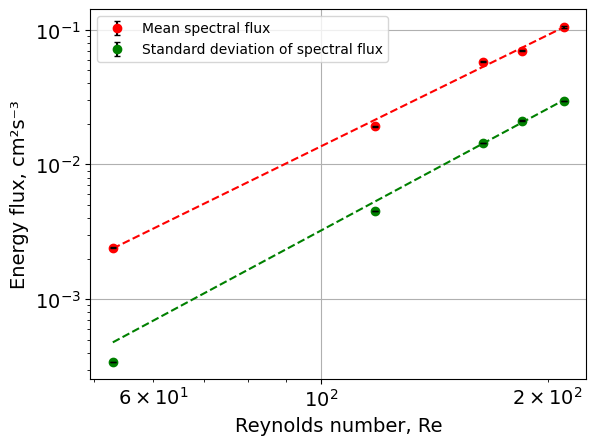

In [ ]:
Re = np.array([53, 118, 164, 185, 210])
meanP = np.array([mean_j0070, mean_j0250, mean_j0460, mean_j0580, mean_j0700])
stdP = np.array([dev_j0070, dev_j0250, dev_j0460, dev_j0580, dev_j0700])
mean_error = np.array([errormean_j0070, errormean_j0250, errormean_j0460, errormean_j0580, errormean_j0700])
dev_error = np.array([errordev_j0070, errordev_j0250, errordev_j0460, errordev_j0580, errordev_j0700])
param_mean = curve_fit(power, Re, meanP)
param_std = curve_fit(power, Re, stdP)
plt.plot(Re, param_mean[0][0] * Re ** param_mean[0][1], 'r--')
plt.plot(Re, param_std[0][0] * Re ** param_std[0][1], 'g--')
plt.errorbar(Re, meanP, yerr=mean_error, fmt="o", ecolor='black', capsize=2, color = 'r', barsabove = 'True', label = 'Mean spectral flux')
plt.errorbar(Re, stdP, yerr=dev_error, fmt="o", ecolor='black', capsize=2, color = 'g', barsabove = 'True', label = 'Standard deviation of spectral flux')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Reynolds number, Re')
plt.ylabel('Energy flux, cm²s⁻³')
plt.legend(prop={'size': 10})
plt.grid()
print(mean_error/meanP * 100)
print(dev_error/stdP * 100)
plt.savefig('flux_reynolds.png', dpi=500)
files.download('flux_reynolds.png')